In [1]:
import zipfile
from glob import glob
import os
from netCDF4 import Dataset
import pandas as pd
import geopandas as gpd # GeoPandas(지오판다스)
from shapely.geometry import Polygon, LineString, Point
path = os.getcwd()

import rasterio
from rasterio.plot import show
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

import numpy as np

### 데이터 전처리 및 점검

* 2013년 기상자료

In [3]:
em_meta.head()

지점         시작일  종료일  지점명                              지점주소         관리관서  \
0  90  1968-01-01  NaN   속초       강원도 고성군토성면 봉포5길9 속초자동기상관측소     속초기상대(90)   
1  93  2016-10-01  NaN  북춘천  강원도 춘천시신북읍 산천리264(장본1길 12) 춘천기상대   춘천기상대(101)   
2  95  1988-01-01  NaN   철원  강원도 철원군갈말읍 명성로179번길 26 철원자동기상관측소   춘천기상대(101)   
3  98  1998-02-01  NaN  동두천       경기도 동두천시방죽로 16-47동두천서비스센터    수도권기상청(119)   
4  99  2013-10-22  NaN   파주      경기도 파주시문산읍 마정로46-29(파주기상대)    수도권기상청(119)   

        위도        경도  노장해발고도(m)  기압계(관측장비지상높이(m))  기온계(관측장비지상높이(m))  \
0  38.2509  128.5647      17.53             18.73               1.7   
1  37.9474  127.7544      95.78             96.78               1.5   
2  38.1479  127.3042     155.48            156.98               1.8   
3  37.9019  127.0607     115.62            116.74               1.7   
4  37.8859  126.7665      30.59             31.99               1.7   

   풍속계(관측장비지상높이(m))  강우계(관측장비지상높이(m))  
0              10.0               1.4  
1              10.0               1.4  
2              13.0               1.5  
3              10.0               1.0  
4              10.0               1.0

In [4]:
em_df.head()

지점                일시  기온(°C)  강수량(mm)  풍속(m/s)  풍향(16방위)  습도(%)  증기압(hPa)  \
0  254  2013-01-01 00:00    -5.5      NaN      0.4       0.0   92.0       3.8   
1  254  2013-01-01 01:00    -5.7      NaN      0.0       0.0   92.0       3.7   
2  254  2013-01-01 02:00    -5.5      NaN      0.7     140.0   92.0       3.8   
3  254  2013-01-01 03:00    -5.5      NaN      0.7      70.0   92.0       3.8   
4  254  2013-01-01 04:00    -5.2      NaN      0.3       0.0   94.0       3.9   

   이슬점온도(°C)  현지기압(hPa)  ...  운형(운형약어)  최저운고(100m )  시정(10m)  지면상태(지면상태코드)  \
0       -6.5     1006.1  ...       NaN          NaN      NaN           NaN   
1       -6.7     1005.9  ...       NaN          NaN      NaN           NaN   
2       -6.5     1005.9  ...       NaN          NaN      NaN           NaN   
3       -6.5     1005.9  ...       NaN          NaN      NaN           NaN   
4       -6.0     1005.0  ...       NaN          NaN      NaN           NaN   

   현상번호(국내식)  지면온도(°C)  5cm 지중온도(°C) 10cm 지중온도(°C)  20cm 지중온도(°C)  \
0        NaN      -1.7           0.1          -0.7            0.5   
1        NaN      -1.4           0.1          -0.7            0.5   
2        NaN      -1.5           0.1          -0.7            0.5   
3        NaN      -1.5           0.1          -0.7            0.5   
4        NaN      -1.5           0.2          -0.7            0.5   

   30cm 지중온도(°C)  
0            0.7  
1            0.7  
2            0.6  
3            0.7  
4            0.7  

[5 rows x 27 columns]

In [5]:
geo_point = []
for i in range(len(em_meta)):
    x,y = em_meta.loc[i,'경도'], em_meta.loc[i,'위도']
    geo_point.append(Point(x,y))
    

em_meta['geometry'] = geo_point

em_point_gdf = gpd.GeoDataFrame(em_meta, geometry= 'geometry')
em_point_gdf.crs = {'init':'epsg:4326'}

c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
em_point_gdf.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [7]:
em_point_gdf.explore()

* 2013년 pm_10자료
* 2013년자료에는 pm2.5측정자료가 없음(나중에 확인 더 해보기)
* 에어코리아자료
* 공공데이터포털 api에서 메타데이터, 대기오염정보 받을 수 있음(대기오염정보에는 시간대별 예측 이미지도 조회 가능함)
* 외부에서 사용할경우 출처표시 꼭하기(영리목적으로는 사용 불가능한듯)

In [61]:
# # 압축파일 추출
# ziplist_airpolutant_monitoring = glob(os.path.join(path,"시간단위대기질자료","*zip",))
# for i in ziplist_airpolutant_monitoring:
#     # name = os.path.splitext(os.path.basename(i))[0]
#     zipfile.ZipFile(i).extractall(path=os.path.join(path,"시간단위대기질자료","rawdata","extract",))


In [62]:
airpolutant_monitoring_2013_list = glob(os.path.join(path,"시간단위대기질자료","rawdata","extract","2013*",))

In [63]:
airpolutant_monitoring_2013_list

['c:\\Users\\Go\\OneDrive - UOS\\allrepos\\UNet-project (2)\\시간단위대기질자료\\rawdata\\extract\\2013│Γ01║╨▒Γ.xlsx',
 'c:\\Users\\Go\\OneDrive - UOS\\allrepos\\UNet-project (2)\\시간단위대기질자료\\rawdata\\extract\\2013│Γ02║╨▒Γ.xlsx',
 'c:\\Users\\Go\\OneDrive - UOS\\allrepos\\UNet-project (2)\\시간단위대기질자료\\rawdata\\extract\\2013│Γ03║╨▒Γ.xlsx',
 'c:\\Users\\Go\\OneDrive - UOS\\allrepos\\UNet-project (2)\\시간단위대기질자료\\rawdata\\extract\\2013│Γ04║╨▒Γ.xlsx']

In [64]:
data_list = []
for i in airpolutant_monitoring_2013_list:
    temp_data = pd.read_excel(i)
    data_list.append(temp_data)

In [65]:
air_pol_2013 = pd.concat(data_list)

In [66]:
air_pol_2013

지역 측정소명   측정소코드        측정일시     SO2   CO     O3     NO2  PM10  \
0           서울   중구  111121  2013010101  0.0060  1.1  0.003  0.0610    30   
1           서울   중구  111121  2013010102  0.0060  1.1  0.003  0.0580    42   
2           서울   중구  111121  2013010103  0.0060  0.9  0.003  0.0510    46   
3           서울   중구  111121  2013010104  0.0060  0.9  0.004  0.0460    30   
4           서울   중구  111121  2013010105  0.0050  0.8  0.005  0.0390    25   
...        ...  ...     ...         ...     ...  ...    ...     ...   ...   
699931  인천 옹진군  백령도  831492  2013123120  0.0085  0.6  0.023  0.0110   209   
699932  인천 옹진군  백령도  831492  2013123121  0.0086  0.8  0.023  0.0107   189   
699933  인천 옹진군  백령도  831492  2013123122  0.0048  0.3  0.032  0.0037   172   
699934  인천 옹진군  백령도  831492  2013123123  0.0042  0.2  0.032  0.0023   127   
699935  인천 옹진군  백령도  831492  2013123124  0.0042  0.2  0.032  0.0021   121   

                    주소  
0           서울 중구 서소문동  
1           서울 중구 서소문동  
2           서울 중구 서소문동  
3           서울 중구 서소문동  
4           서울 중구 서소문동  
...                ...  
699931  인천 옹진군 백령면 연화리  
699932  인천 옹진군 백령면 연화리  
699933  인천 옹진군 백령면 연화리  
699934  인천 옹진군 백령면 연화리  
699935  인천 옹진군 백령면 연화리  

[2766000 rows x 10 columns]

In [8]:
import requests
import time
url = 'http://apis.data.go.kr/B552584/MsrstnInfoInqireSvc/getMsrstnList'
key = "k5wXUhoJHwee1cncQCBmm81YbQ+exttb0vdJcyF5GuGJn0mbGBNNL/ER2VfkrJMlExfc+FZjPeRuOM2bvgDYyQ=="

# params ={'serviceKey' : key, 'addr': '서울', 'stationName': '종로구', 'pageNo': 1, 'numOfRows': 10,'returnType': 'json'}
params ={'serviceKey' : key, 'pageNo': 1, 'numOfRows': 640,'returnType': 'json'}
response = requests.get(url, params=params, verify=False)

data_dic = response.json()
site_info = pd.DataFrame(data_dic['response']['body']['items'])
    

In [9]:
site_info

dmX                           item mangName  year  \
0       35.1708927  SO2, CO, O3, NO2, PM10, PM2.5     도시대기  2005   
1        35.182668  SO2, CO, O3, NO2, PM10, PM2.5     도시대기  2020   
2         35.08298  SO2, CO, O3, NO2, PM10, PM2.5     도시대기  1991   
3         35.20958  SO2, CO, O3, NO2, PM10, PM2.5     도시대기  1999   
4       35.0866322  SO2, CO, O3, NO2, PM10, PM2.5     도시대기  2019   
..             ...                            ...      ...   ...   
635  34.8943055556  SO2, CO, O3, NO2, PM10, PM2.5       항만  None   
636      33.500116  SO2, CO, O3, NO2, PM10, PM2.5     도시대기  1994   
637       33.48863  SO2, CO, O3, NO2, PM10, PM2.5     도시대기  2006   
638      33.539831  SO2, CO, O3, NO2, PM10, PM2.5     도시대기  2020   
639      33.409109  SO2, CO, O3, NO2, PM10, PM2.5     도시대기  2020   

                                                  addr stationName  \
0                            부산 해운대구 양운로 91 좌1동주민센터 옥상          좌동   
1                    부산광역시 해운대구 센텀동로 191 동부하수처리장 (재송동)         재송동   
2                       부산 사하구 장림로 161번길 2 장림1동주민센터 옥상         장림동   
3                     부산광역시 강서구 체육공원로 43 강서체육공원 (대저1동)         대저동   
4                부산 강서구 녹산산단 382로 49번길 39 부산환경공단 녹산사업소         녹산동   
..                                                 ...         ...   
635                       전남 광양시 광양읍 율촌산단7로 111 율촌일반부두       광양 율촌   
636                      제주 제주시 이도2동 1176-1(제주시청) 제주시청         이도동   
637  제주 제주시 연동 322-1 번지 제주특별자치도청 제2청사 제주특별자치도청 제2청사 옥상          연동   
638                 제주특별자치도 제주시 조천읍 조천18길 11-1 조천읍 체육관         조천읍   
639                 제주특별자치도 제주시 한림읍 한림중앙로 71-9 한림읍 체육관         한림읍   

             dmY  
0    129.1741659  
1     129.118136  
2    128.9667622  
3    128.9713671  
4       128.8639  
..           ...  
635    127.61225  
636   126.532371  
637   126.500055  
638    126.64412  
639   126.268778  

[640 rows x 7 columns]

In [10]:
point_list = []
for i in range(len(site_info)):
    try:
        point_list.append(Point(float(site_info.dmY[i]), float(site_info.dmX[i])))
    except:
        point_list.append(None)

site_info.loc[:,'geometry'] = point_list
site_info_dropna = site_info.loc[~site_info.isna().dmX.values]

site_info_dropna = gpd.GeoDataFrame(site_info_dropna, geometry = 'geometry')
site_info_dropna.crs = em_point_gdf.crs


c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [11]:
site_info_dropna.explore()

* cdf자료랑 좌표 병합 체크

In [12]:
emis_list = glob(os.path.join('d:\Emission',"RSM_2_Apr_Jul","RSM_2","*"))
concentration_list = glob(os.path.join('d:\Concentration',"RSM_2_ACONC","RSM_2","*"))

In [13]:
emis_list[:3]

['d:\\Emission\\RSM_2_Apr_Jul\\RSM_2\\egts_l.20130322.1.KNU_09_01.RSM_2.ncf',
 'd:\\Emission\\RSM_2_Apr_Jul\\RSM_2\\egts_l.20130323.1.KNU_09_01.RSM_2.ncf',
 'd:\\Emission\\RSM_2_Apr_Jul\\RSM_2\\egts_l.20130324.1.KNU_09_01.RSM_2.ncf']

In [14]:
concentration_list[:3]

['d:\\Concentration\\RSM_2_ACONC\\RSM_2\\CCTM_GUIDE_RSM_Linux2_x86_64mpif90.GUIDE.RSM.ACONC.2012366.ncf',
 'd:\\Concentration\\RSM_2_ACONC\\RSM_2\\CCTM_GUIDE_RSM_Linux2_x86_64mpif90.GUIDE.RSM.ACONC.2013011.ncf',
 'd:\\Concentration\\RSM_2_ACONC\\RSM_2\\CCTM_GUIDE_RSM_Linux2_x86_64mpif90.GUIDE.RSM.ACONC.2013081.ncf']

In [15]:
emis_temp = Dataset(emis_list[0], 'r')
concen_temp = Dataset(concentration_list[0], 'r')

In [16]:
concen_temp.variables['NO'][0,0,:,:]

masked_array(
  data=[[0.000302  , 0.000292  , 0.00028573, ..., 0.000149  , 0.00012452,
         0.00014855],
        [0.00032988, 0.00029467, 0.00028484, ..., 0.00014785, 0.00012816,
         0.00014471],
        [0.00028465, 0.0002768 , 0.00026787, ..., 0.00013888, 0.00013164,
         0.00017304],
        ...,
        [0.00016967, 0.00016838, 0.00016368, ..., 0.00011838, 0.00013117,
         0.00013219],
        [0.00019131, 0.00018042, 0.0001669 , ..., 0.00012841, 0.00014033,
         0.00013557],
        [0.00019477, 0.00019304, 0.00016172, ..., 0.00013639, 0.0001435 ,
         0.00013513]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [17]:
emis_temp.variables['NO'][0,0,:,:]  # NO값 0시에 연직첫번쨰레이어 전체그리드값

masked_array(
  data=[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

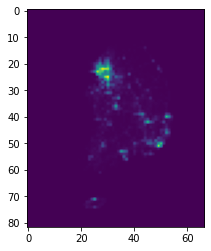

In [18]:
plt.imshow(emis_temp.variables['NO'][0,0,:,:][::-1])

In [19]:
emis_test = emis_temp.variables['NO'][0,0,:,:][::-1]

transform = from_origin(-180000 , 153000 , 9000, 9000)
profile = {'driver': 'GTiff', 'height': emis_test.shape[0], 'width': emis_test.shape[1], 'count': 1, 'dtype': str(emis_test.dtype), 'transform': transform}
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# with rasterio.open(os.path.join(path,"test.tif"), 'w', crs='EPSG:5181', **profile) as dst:
with rasterio.open(os.path.join(path,"emis_test.tif"), 'w', crs=projout, **profile) as dst:
     dst.write(emis_test,1)

# emis_test_raster = rasterio.open(os.path.join(path,"emis_test.tif"))
with rasterio.open(os.path.join(path,"emis_test.tif")) as src:
    print(src.shape)

(82, 67)


In [20]:
concen_test = concen_temp.variables['NO'][0,0,:,:][::-1]

transform = from_origin(-180000 , 153000 , 9000, 9000)
profile = {'driver': 'GTiff', 'height': concen_test.shape[0], 'width': concen_test.shape[1], 'count': 1, 'dtype': str(concen_test.dtype), 'transform': transform}
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# with rasterio.open(os.path.join(path,"test.tif"), 'w', crs='EPSG:5181', **profile) as dst:
with rasterio.open(os.path.join(path,"concen_test.tif"), 'w', crs=projout, **profile) as dst:
     dst.write(concen_test,1)

with rasterio.open(os.path.join(path,"concen_test.tif")) as src:
    print(src.shape)

(82, 67)


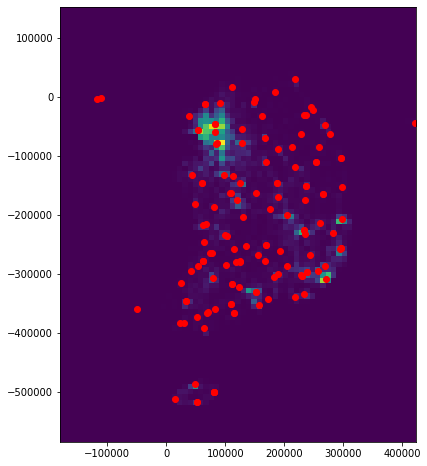

In [21]:

with rasterio.open(os.path.join(path,"emis_test.tif")) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)
    em_point_gdf.to_crs(projout).plot(ax=ax,color = 'red') # site_info_dropna
    # site_info_dropna.to_crs(projout).plot(ax=ax,color = 'yellow')

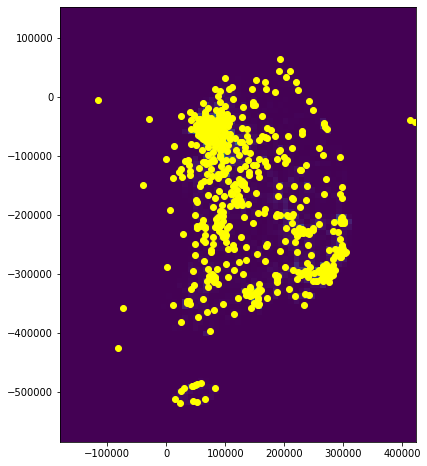

In [22]:
with rasterio.open(os.path.join(path,"emis_test.tif")) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)
    # em_point_gdf.to_crs(projout).plot(ax=ax,color = 'red') # site_info_dropna
    site_info_dropna.to_crs(projout).plot(ax=ax,color = 'yellow')

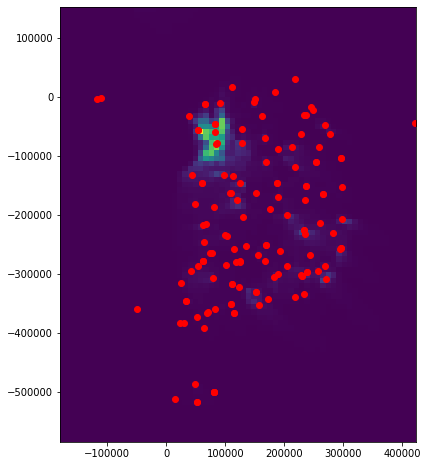

In [23]:
with rasterio.open(os.path.join(path,"concen_test.tif")) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)
    em_point_gdf.to_crs(projout).plot(ax=ax,color = 'red') # site_info_dropna
    # site_info_dropna.to_crs(projout).plot(ax=ax,color = 'yellow')

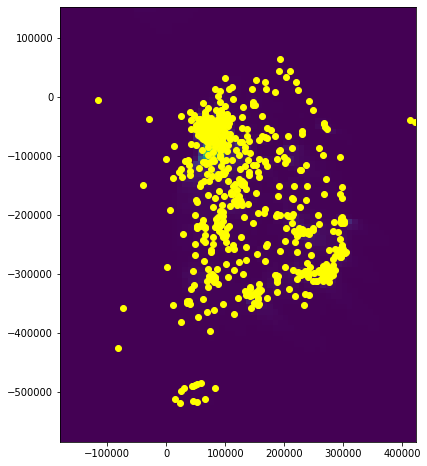

In [24]:
with rasterio.open(os.path.join(path,"concen_test.tif")) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)
    # em_point_gdf.to_crs(projout).plot(ax=ax,color = 'red') # site_info_dropna
    site_info_dropna.to_crs(projout).plot(ax=ax,color = 'yellow')

In [25]:
x_m = list(range(-180000,-180000 + 9000 * 67, 9000))
y_m = list(range(-585000,-585000 + 9000 * 82, 9000))

print(len(x_m), len(y_m))
x, y = np.meshgrid(x_m, y_m)

grid_points = []
for i in range(len(x)):
    for j in range(len(y[0,:])):
        # print(x[i,j],y[i,j])
        grid_points.append(Point(x[i,j],y[i,j]))

grid_data = pd.DataFrame(grid_points, columns=['geometry'])

grid_data = gpd.GeoDataFrame(grid_data, geometry='geometry')
grid_data.crs = em_point_gdf.to_crs(projout).crs
grid_data.loc[:,'x'] = grid_data.geometry.x
grid_data.loc[:,'y'] = grid_data.geometry.y
m = grid_data.explore()
em_point_gdf.to_crs(grid_data.crs).explore(m=m, color = 'black')

67 82


c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [26]:
x_m = list(range(-180000,-180000 + 9000 * 67, 9000))
y_m = list(range(-585000,-585000 + 9000 * 82, 9000))

print(len(x_m), len(y_m))
x, y = np.meshgrid(x_m, y_m)

grid_points = []
for i in range(len(x)):
    for j in range(len(y[0,:])):
        # print(x[i,j],y[i,j])
        grid_points.append(Point(x[i,j],y[i,j]))

grid_data = pd.DataFrame(grid_points, columns=['geometry'])

grid_data = gpd.GeoDataFrame(grid_data, geometry='geometry')
grid_data.crs = em_point_gdf.to_crs(projout).crs
grid_data.loc[:,'x'] = grid_data.geometry.x
grid_data.loc[:,'y'] = grid_data.geometry.y
m = grid_data.explore()
site_info_dropna.to_crs(grid_data.crs).explore(m=m, color = 'black')

67 82


c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


### 학습용 데이터셋 구축

In [28]:
# 2013년0일0시 기상데이터
test_data = pd.merge(em_df.loc[em_df.일시 == em_df.일시.values[0], :], em_point_gdf.loc[:,['지점', 'geometry','위도','경도']], how='left', on='지점')
test_data = gpd.GeoDataFrame(test_data, geometry='geometry')
test_data.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [29]:
test_data.columns

Index(['지점', '일시', '기온(°C)', '강수량(mm)', '풍속(m/s)', '풍향(16방위)', '습도(%)',
       '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)', '일조(hr)',
       '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)', '전운량(10분위)', '중하층운량(10분위)',
       '운형(운형약어)', '최저운고(100m )', '시정(10m)', '지면상태(지면상태코드)', '현상번호(국내식)',
       '지면온도(°C)', '5cm 지중온도(°C)', '10cm 지중온도(°C)', '20cm 지중온도(°C)',
       '30cm 지중온도(°C)', 'geometry', '위도', '경도'],
      dtype='object')

* 측정망자료 epsg4326 레스터화
* epsg4326레스터 to lcc 
* 같이 그려서 머지확인

In [31]:
from geocube.api.core import make_geocube
import seaborn as sns

* 베이스 레스터 제작

68 83


c:\Users\Go\anaconda3\envs\tensorgpu\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


(82, 67) -180000.0 153000.0 423000.0 -585000.0


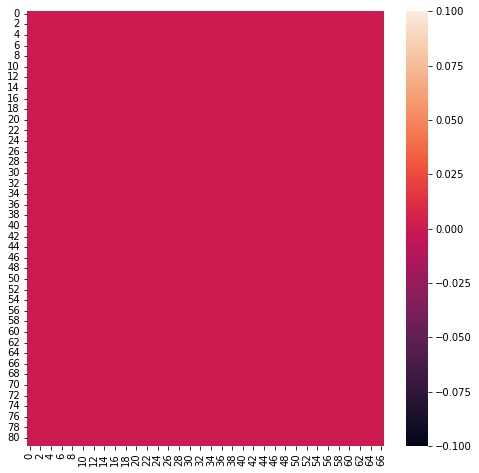

In [50]:
# 기본맵 레스터 제작
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
x_m = list(range(-180000,-180000 + 9000 * 68, 9000))
y_m = list(range(-585000,-585000 + 9000 * 83, 9000))

print(len(x_m), len(y_m))

grid_points = []
for x_i in x_m:
    for y_i in y_m:
        grid_points.append(Point(x_i,y_i))

grid_data = pd.DataFrame(grid_points, columns=['geometry'])

grid_data = gpd.GeoDataFrame(grid_data, geometry='geometry')
grid_data.crs = em_point_gdf.to_crs(projout).crs
grid_data.loc[:,'x_m'] = grid_data.geometry.x
grid_data.loc[:,'y_m'] = grid_data.geometry.y
grid_data.loc[:,'value'] = 0

out_grid = make_geocube(vector_data=grid_data, measurements=["value"],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid["value"].rio.to_raster("my_rasterized_column3.tif")

with rasterio.open(os.path.join(path,"my_rasterized_column3.tif")) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    # show(src, ax=ax)
    sns.heatmap(src.read(1),ax=ax)
    print(src.read(1).shape, src.bounds.left, src.bounds.bottom , src.bounds.right, src.bounds.top)
    # del rasterized_test_raster

* 측정망 레스터 제작 및 좌표 일치하나 확인

(46, 29)
(82, 67)


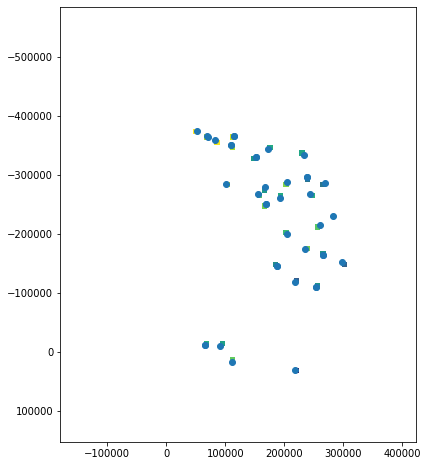

In [91]:
# 측정망자료 레스터화
projout = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

# out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"], geom=geom,resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid = make_geocube(vector_data=test_data, measurements=["습도(%)"],resolution=(9000, 9000), fill=0, output_crs=projout) #for most crs negative comes first in resolution
out_grid["습도(%)"].rio.to_raster("my_rasterized_column2.tif")
# test_data.to_crs(5181).plot(ax=ax)
with rasterio.open(os.path.join(path,"my_rasterized_column2.tif")) as src, rasterio.open(os.path.join(path,"my_rasterized_column3.tif")) as src2:
    fig, ax = plt.subplots(figsize=(8, 8))
    print(src.read(1).shape,)
    show(src, ax=ax)

    test_data.to_crs(projout).plot(ax=ax)
    print(src2.read(1).shape,)
    show(src2, ax=ax)
    # del rasterized_test_raster

* lcc로 변환 한번 더, 이거 안하면 머지에서 에러나옴 이유는 차차 알아볼 것...

67 82 -180000.0 153000.0 423000.0 -585000.0
(82, 67)


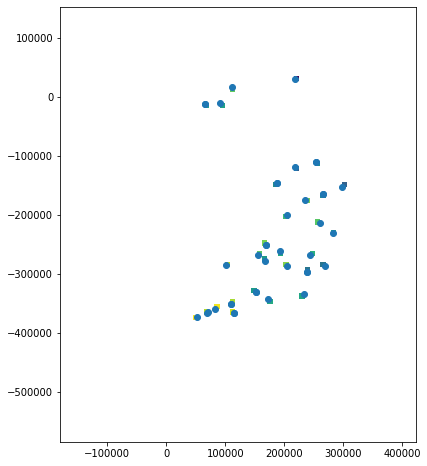

In [123]:
# 레스터 좌표변환
# 5181로 변환하면 좌표들 약간 틀어짐
# lcc로 처리 해야함
from rasterio.warp import calculate_default_transform, reproject, Resampling
# dst_crs = 'epsg: 5181'
dst_crs = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'

with rasterio.open(os.path.join(path,"my_rasterized_column2.tif")) as src:

    transform, width, height = calculate_default_transform(
                    src.crs, 
                    dst_crs, 
                    src.width, 
                    src.height, 
                    *src.bounds)
   
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(os.path.join(path,"my_rasterized_column2_lcc.tif"), 'w', **kwargs) as dst:
            
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

with rasterio.open(os.path.join(path,"my_rasterized_column3.tif")) as src:
    print(src.width, src.height, *src.bounds,)
    transform, width, height = calculate_default_transform(
                    src.crs, 
                    dst_crs, 
                    src.width, 
                    src.height, 
                    *src.bounds)
   
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(os.path.join(path,"my_rasterized_column3_lcc.tif"), 'w', **kwargs) as dst:
            
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                
with rasterio.open(os.path.join(path,"my_rasterized_column2_lcc.tif")) as src, rasterio.open(os.path.join(path,"my_rasterized_column3_lcc.tif")) as src2:
    fig, ax = plt.subplots(figsize=(8, 8))

    show(src, ax=ax)
    show(src2, ax=ax)
    test_data.to_crs(dst_crs).plot(ax=ax)
    print(src2.read(1).shape)

* 머지해서 측정망 값 있는 자료 (67,82) 파일로 생성

(82, 67)


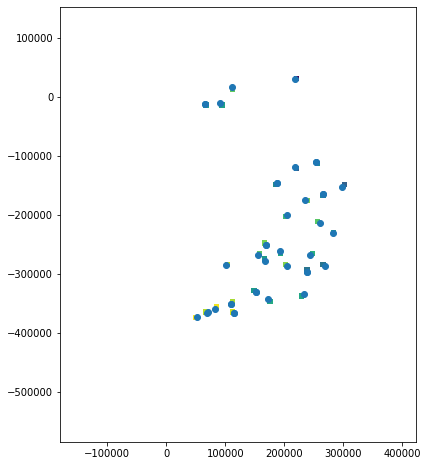

In [125]:
from rasterio.merge import merge
with rasterio.open(os.path.join(path,"my_rasterized_column2_lcc.tif")) as src, rasterio.open(os.path.join(path,"my_rasterized_column3_lcc.tif")) as src2:
    raster_list = [src, src2]
    # print(src.read(1).shape, src2.read(1).shape,)
    mosaic, output = merge(raster_list)

    output_meta = src2.meta.copy()
    output_meta.update(
        {"driver": "GTiff",
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": output,
        }
    )

    with rasterio.open(os.path.join(path,"raster_sized_column_lcc.tif"), "w", **output_meta) as m:
        m.write(mosaic)


with rasterio.open(os.path.join(path,"raster_sized_column_lcc.tif")) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    
    show(src, ax=ax)
    test_data.to_crs(dst_crs).plot(ax=ax)

    # site_info_dropna.plot(ax=ax,color = 'yellow')

    print(src.read(1).shape)

* 농도자료랑도 일치하는가 확인

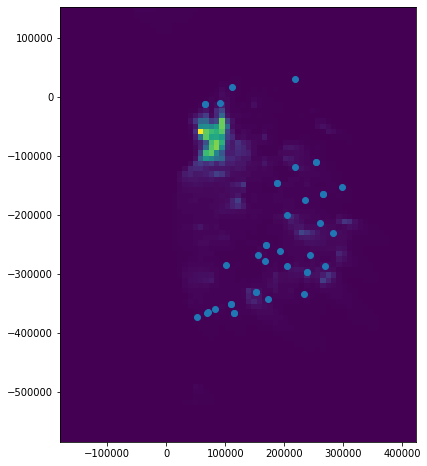

In [128]:
import seaborn as sns
import matplotlib

with rasterio.open(os.path.join(path,"concen_test.tif")) as src:
    fig, ax = plt.subplots(figsize=(8, 8))
    show(src, ax=ax)
    test_data.to_crs(dst_crs).plot(ax=ax)